In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.stats import rankdata
import pandas as pd
import pickle
import lightgbm
import os
from lime import lime_tabular
import sys
sys.path.append('..')
from lirme_v2 import LIRME
from sklearn.utils import shuffle
from scipy.stats import spearmanr, kendalltau
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
sys.path.append('..')
from get_exp_new import lime_exp, shap_exp, random_exp, grad_exp
from greedy_score import Greedy
from sklearn.metrics import ndcg_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
gt = np.array([0.2, -0.3, 0.5, 0, 0])

In [4]:
def S(D):
    scores = D[:, 0] * 0.2 - 0.3 * D[:, 1] + 0.5 * D[:, 2] #+ np.random.normal(0, 0.1)
    return len(scores) - rankdata(scores).astype(int)

def prepare_data():
    df_train = pickle.load( open( "./synthetic_train.p", "rb" ) )
    df_test = pickle.load( open( "./synthetic_test.p", "rb" ) )
    
    qids_train = df_train.groupby(0)[0].count().to_numpy()
    X_train = df_train.drop([0, 6], axis = 1)
    y_train = df_train.iloc[:, 6].astype(int)

    qids_test = df_test.groupby(0)[0].count().to_numpy()
    X_test = df_test.drop([0, 6], axis = 1)
    y_test = df_test.iloc[:, 6].astype(int)
    
    return X_train, y_train, qids_train, X_test, y_test, qids_test

data = []
q_id = []

for i in range(1000): 
    mu = 0
    sigma = 0.4
    q_id.append(np.repeat(i, 10))
    data.append(np.random.normal(mu, sigma, (10, 5)))


scores = []
for i in range(len(data)):
    scores.append(S(data[i]))
scores = np.array(scores).reshape(1000*10)

data = np.array(data).reshape(1000 * 10, 5)

q_id = np.array(q_id).flatten()


data_df = pd.DataFrame(np.c_[q_id, data, scores])

all_instances = data_df.iloc[:, 0].unique()
q_train_idx = np.random.choice(all_instances, 800, replace=False)
q_test_idx = np.setxor1d(all_instances, q_train_idx)

df_train = data_df[data_df.iloc[:, 0].isin(q_train_idx)]
df_test = data_df[data_df.iloc[:, 0].isin(q_test_idx)]

pickle.dump(df_train, open( "./synthetic_train.p", "wb" ))
pickle.dump(df_test, open( "./synthetic_test.p", "wb" ))

In [5]:
df_train = pickle.load( open( "./data/synthetic_train.p", "rb" ) )
df_test = pickle.load( open( "./data/synthetic_test.p", "rb" ) )

train_scaled = df_train.drop([6], axis=1).values
valid_scaled = df_test.drop([6], axis=1).values

X_train, y_train, qids_train, X_test, y_test, qids_test = prepare_data()

ranker = lightgbm.LGBMRanker(
                    objective="lambdarank",
                    boosting_type = "gbdt",
                    n_estimators = 5,
                    importance_type = "gain",
                    metric= "ndcg",
                    num_leaves = 10,
                    learning_rate = 0.05,
                    max_depth = -1,
                    label_gain =[i for i in range(max(y_train.max(), y_test.max()) + 1)])

ranker.fit(
      X=X_train,
      y=y_train,
      group=qids_train,
      eval_set=[(X_train, y_train),(X_test, y_test)],
      eval_group=[qids_train, qids_test],
      eval_at=[5, 10])

ranker.booster_.save_model('./models/lmart_synthetic.txt')
pickle.dump(ranker.evals_result_, open( "./models/lmart_synthetic_eval.p", "wb" ) )

In [6]:
ranker = lightgbm.Booster(model_file='./models/lmart_synthetic.txt')
ranker.params['objective'] = 'binary'

lirme = LIRME(valid_scaled[:, 1:])
e_sample_size = 4000

exps = {'lime': [],  'shap': [], 'lirme': [], 'exs_v1': [],  'exs_v2': [], 'grad_d': [], 'random_d': []}

for i in range(400):
    if i % 10 == 0:
        print(i)
    instance = valid_scaled[i, 1:]#.reshape(1, -1)
    train_background = train_scaled[:, 1:]
    
    exps['lime'].append(lime_exp(instance, ranker, train_background, sample_size=e_sample_size))
    exps['shap'].append(shap_exp(instance, train_background, ranker, sample_size=e_sample_size))
    
    all_related_docs = np.argwhere(valid_scaled[i][0] == valid_scaled[:, 0]).flatten()
    all_related_docs_preds = ranker.predict(valid_scaled[all_related_docs, 1:])

    exp_lirme = lirme.explain(instance, ranker.predict, all_related_docs_preds, 
                sur_type='ridge', label_type='regression', 
                instance_idx=i, top_rank=5, sample_size=e_sample_size)
    exps['lirme'].append(exp_lirme)

    gradient_exp = grad_exp(instance, ranker)
    exps['grad_d'].append(gradient_exp)

    exp_exs_v1 = lirme.explain(instance, ranker.predict, all_related_docs_preds, 
                sur_type='svm', label_type='top_k_binary', 
                instance_idx=i, top_rank=5, sample_size=e_sample_size)
    exps['exs_v1'].append(exp_exs_v1)

    exp_exs_v2 = lirme.explain(instance, ranker.predict, all_related_docs_preds, 
                sur_type='svm', label_type='score', 
                instance_idx=i, top_rank=5, sample_size=e_sample_size)
    exps['exs_v2'].append(exp_exs_v2)
    
    exps['random_d'].append(random_exp(instance.shape[0]))

pickle.dump(exps, open( "./synthetic_exps.p", "wb" ) )

In [7]:
exps = pickle.load( open( "./exps/synthetic_exps.p", "rb" ) )

subset_test = df_test.iloc[:400]
from listwise_exp import pmi_exp, rpi_exp, grad_q_exp, greedy_exp, random_q_exp
from ranklime import RankLIME
rlime = RankLIME(valid_scaled[:1000, 1:])

q_exps = {'pmi': [], 'rpi': [], 'grad': [], 'rank_lime': [], 'greedy_score': [], 'random': []}


#q_exps = {'pmi': [],  'rank_lime': [], 'greedy_score': [], 'random': []}

for i, row in subset_test.groupby(0):
    if i % 10 == 0:
        print(i)
    doc_values = row.loc[:, 1:5].values
    
    q_exps['pmi'].append(pmi_exp(doc_values, ranker))
    q_exps['rpi'].append(rpi_exp(doc_values, ranker))
    q_exps['grad'].append(grad_q_exp(doc_values, ranker))
    q_exps['rank_lime'].append(rlime.explain(doc_values, ranker.predict, []))
    q_exps['greedy_score'].append(greedy_exp(doc_values, ranker.predict))
    q_exps['random'].append(random_q_exp(doc_values))

pickle.dump(q_exps, open( "./synthetic_query_exps_v1.p", "wb" ) )

In [15]:
q_exps = pickle.load( open( "./exps/synthetic_query_exps.p", "rb" ) )

In [16]:
indices = np.arange(0, 410, 10)

In [17]:
l_exp = {}
for e in exps.keys():
    l_exp[e] = []
    for i in range(len(indices) - 1):        
        l_exp_val = np.array(exps[e][indices[i]:indices[i+1]])
        l_exp[e].append(np.sum(l_exp_val, axis=0))
for e in l_exp:
    q_exps[e] = l_exp[e]

In [18]:
accuracy = {}
for e in q_exps.keys():
    accuracy[e] = 0
    s_ranks_ = []
    for i in range(len(q_exps[e])):
        s_ranks_.append(kendalltau(q_exps[e][i], gt).statistic)
    
    accuracy[e] = np.nanmean(s_ranks_)

In [19]:
top_k = 2
fidelity_non_ltr = {}
for e in q_exps.keys():
    fidelity_non_ltr[e] = 0
    temp = []
    for i in range(len(indices) - 1):
        doc_values = valid_scaled[indices[i]:indices[i+1], 1:].copy()
        doc_values_p = doc_values.copy()
        
        # perturb the doc_values based on exp
        q_exp_val = q_exps[e][i].flatten()
        top_features =  np.argsort(np.abs(q_exp_val))[-top_k:][::-1]
        doc_values_p[:, top_features]  =  np.mean(valid_scaled[:, top_features], axis=0)
        
        output_0 = ranker.predict(doc_values)
        output_1 = ranker.predict(doc_values_p)
        output = np.abs(output_1 - output_0)
        
        prod = np.dot(doc_values_p, q_exp_val)
        
        temp.append(kendalltau(prod, output).statistic)
    fidelity_non_ltr[e] = np.nanmean(temp)

Mean of empty slice


In [21]:
top_k = 2
fidelity_ltr = {}
for e in q_exps.keys():
    fidelity_ltr[e] = 0
    temp = []
    
    for i in range(len(indices) - 1):
        doc_values = valid_scaled[indices[i]:indices[i+1], 1:].copy()
        doc_values_p = doc_values.copy()
        
        # perturb the doc_values based on exp
        q_exp_val = q_exps[e][i].flatten()
        #top_features =  np.argsort(np.abs(q_exp_val))[-top_k:][::-1]
        #doc_values_p[:, top_features]  =  np.mean(valid_scaled[:, top_features], axis=0)
        
        prod = np.dot(doc_values_p, q_exp_val)
        output = ranker.predict(doc_values_p)
        temp.append(kendalltau(prod, output).statistic)
    fidelity_ltr[e] = np.nanmean(temp)

In [22]:
def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

In [23]:
## Explain NCDG@10

explain_ndcg = {}
for e in q_exps.keys():
    explain_ndcg[e] = []
    temp = []
    for i in range(len(indices) - 1):
        doc_values = valid_scaled[indices[i]:indices[i+1], 1:].copy()
        doc_values_p = doc_values.copy()

        # perturb the doc_values based on exp
        q_exp_val = q_exps[e][i].flatten()
        #top_features =  np.argsort(np.abs(q_exp_val))[-top_k:][::-1]
        #doc_values_p[:, top_features]  =  np.mean(background[:, top_features], axis=0)

        prod = np.dot(doc_values, q_exp_val)
        
        output = min_max(ranker.predict(doc_values_p))
        
        #temp.append(kendalltau(prod, output).statistic)
        temp.append(ndcg_score([output], [prod], k=10))
    explain_ndcg[e] = np.nanmean(temp)

In [24]:
e_ndcg = pd.DataFrame(explain_ndcg, index=['Explain NDCG']).round(2)

In [25]:
q_exps.keys()

dict_keys(['pmi', 'rpi', 'grad', 'rank_lime', 'greedy_score', 'random', 'lime', 'shap', 'lirme', 'exs_v1', 'exs_v2', 'grad_d', 'random_d'])

In [26]:
from query_robustness import query_importance_by_perturbation_rank
grouped_data = []

for i in range(len(indices) - 1):
    grouped_data.append(valid_scaled[indices[i]:indices[i+1], 1:].copy())
    
deletion = query_importance_by_perturbation_rank(q_exps, grouped_data, ranker, del_type='deletion')
preservation = query_importance_by_perturbation_rank(q_exps, grouped_data, ranker, del_type='preservation')

robust = {'synthetic': {'deletion': deletion, 'preservation': preservation}}
pickle.dump( robust, open( "robust_synthetic_v1.p", "wb" ) )

pmi
rpi
grad
rank_lime
greedy_score
random
lime
shap
lirme
exs_v1
exs_v2
grad_d
random_d
pmi
rpi
grad
rank_lime
greedy_score
random
lime
shap
lirme
exs_v1
exs_v2
grad_d
random_d


In [ ]:
## DPFF and Robustness

In [27]:
def get_auc(res, robust_type):
    cutoffs = np.linspace(0.05, 0.45, 10)
    auc = {}
    dataset_names = list(res.keys())
    
    for i in range(len(dataset_names)):
        auc[dataset_names[i]] = {}
        temp_res = []
        data_name = dataset_names[i]
        res_ins = res[dataset_names[i]][robust_type]
        exp_names = list(res_ins.keys())
        for j in range(len(exp_names)):        

            temp = np.array(res_ins[exp_names[j]]).mean(axis=1)
            auc_ = 0
            for k in range(1, len(cutoffs) - 1):
                x = cutoffs[k] - cutoffs[k - 1]
                y = temp[k] + temp[k-1]
                auc_ += y / ( 2 * x)
            auc[dataset_names[i]][exp_names[j]] = auc_ 
    return auc

In [28]:
#deletion = np.load('./synthetic_deletion.npy', allow_pickle=True)
#preservation = np.load('./synthetic_preservation.npy', allow_pickle=True)

In [29]:
robust = pickle.load(open( "robust_synthetic_v1.p", "rb" ) )

In [30]:
del_res = get_auc(robust, 'deletion')
per_res = get_auc(robust, 'preservation')

In [31]:
pd.DataFrame([del_res['synthetic'],per_res['synthetic']], index=['deletion', 'preservation']).round(2)

,pmi,rpi,grad,rank_lime,greedy_score,random,lime,shap,lirme,exs_v1,exs_v2,grad_d,random_d
deletion,43.85,18.27,25.16,19.22,23.13,31.36,41.69,42.19,41.74,37.24,38.90,37.35,28.24
preservation,0.00,24.59,7.20,13.64,8.42,6.48,0.31,0.00,1.13,3.15,1.85,5.72,7.56


In [32]:
def get_dp_query(model, data, all_feat_names, evals):
    tree_logic = model.trees_to_dataframe()
    num_estimators = model.num_trees()

    all_dec_paths = []

    for j in range(num_estimators):
    #for j in [4]:
        temp = []
        this_tree_decision_path = np.zeros((data.shape[0], data.shape[1]))
        
        for i in range(data.shape[0]):
            instance = data[i]
            decision_path = np.zeros(data.shape[1])
            len_decision_paths = []

            tree_idx = j
            tree_info = tree_logic[tree_logic['tree_index'] == tree_idx]
            root_node = tree_info[tree_info['parent_index'].values == None]
            node_info = root_node
            
            while (not (node_info['left_child'].values[0] == None and node_info['right_child'].values[0] == None)):
                split_feat = node_info['split_feature'].values
                
                feat_idx = np.argwhere(all_feat_names == split_feat).flatten()[0]
                
                #this_tree_decision_path[i, feat_idx] += 1 * (node_info['node_depth'].values) * (1/(node_info['weight'].values + 0.0001))
                this_tree_decision_path[i, feat_idx] += 1 
                
                if root_node['decision_type'].values == '<=': 
                    condition = instance[feat_idx] <= node_info['threshold'].values[0]
                else: 
                    condition = instance[feat_idx] > node_info['threshold'].values[0]

                if condition == False:
                    node_id = node_info['right_child'].values[0]

                    node_info = tree_logic[tree_logic['node_index'] == node_id]
                else: 
                    node_id = node_info['left_child'].values[0]

                    node_info = tree_logic[tree_logic['node_index'] == node_id]

        #all_dp_paths = np.sum(this_tree_decision_path, axis=0) / data.shape[0]
        all_dp_paths = np.sum(this_tree_decision_path, axis=0) #/ data.shape[0]
        #print(all_dp_paths)
        #all_dp_paths *= evals['valid_1']['ndcg@5'][tree_idx]
        
        all_dec_paths.append(all_dp_paths)
    
    '''final_vector = []
    for path in all_dec_paths:
        if np.sum(path) != 0:
            final_vector.append(path)
    
    final_vector = np.array(final_vector)
    
    f_path = np.mean(final_vector, axis=0)'''
    all_dec_paths = np.mean(np.array(all_dec_paths), axis=0) #/ num_estimators
    
    return all_dec_paths

In [33]:
evals = pickle.load( open( "./models/lmart_synthetic_eval.p", "rb" ) )
dp_accuracy = {}

for e in q_exps.keys():
    dp_accuracy[e] = 0
    temp = []
    for i in range(len(indices) - 1):
        q_exp_val = q_exps[e][i].flatten()
        q_truth = get_dp_query(ranker, valid_scaled[indices[i]:indices[i+1], 1:], ['1', '2', '3', '4', '5'], evals)
        temp.append(kendalltau(q_exp_val, q_truth).statistic)
    dp_accuracy[e] = np.nanmean(temp)

In [34]:
q_truth = get_dp_query(ranker, valid_scaled[0:10, 1:], ['1', '2', '3', '4', '5'], evals)

In [35]:
(q_truth / np.sum(q_truth)).round(2)

array([0.1 , 0.32, 0.58, 0.  , 0.  ])

In [36]:
b = pd.DataFrame([del_res['synthetic'],per_res['synthetic']], index=['Completeness', 'Validity']).round(2)
c = pd.DataFrame(fidelity_ltr, index=['Fidelity LTR']).round(2)
f = pd.DataFrame(fidelity_non_ltr, index=['InFidelity']).round(2)
d = pd.DataFrame(accuracy, index=['GT accuracy']).round(2)
a = pd.DataFrame(dp_accuracy, index=['FF Similarity']).round(2)
e = pd.DataFrame(explain_ndcg, index=['ExplainNDCG@10']).round(2)

In [37]:
result = pd.concat([b,  f, c, e, a, d])
#exp_we_care_about = ['pmi', 'rpi', 'grad', 'rank_lime', 'greedy_score', 'lirme', 'exs_v1', 'exs_v2', 'lime', 'shap','random']
#exp_we_care_about_alt = np.array(['PMI',  'RPI', 'Grad', 'Greedy Score', 'RankLIME', 'LIRME', 'EXS (Top-k)', 'EXS (Score)', 'LIME', 'SHAP', 'Random'])

exp_we_care_about = ['pmi',   'greedy_score', 'rank_lime','lirme', 'exs_v1', 'exs_v2', 'lime', 'shap','random']
exp_we_care_about_alt = np.array(['PMI', 'Greedy Score', 'RankLIME', 'LIRME', 'EXS (Top-k)', 'EXS (Score)', 'LIME', 'SHAP', 'Random'])

In [38]:
result = result.filter(exp_we_care_about)
result.columns = exp_we_care_about_alt

In [42]:
result.round(2).style.highlight_max(color = 'lightgreen', axis = 1)

,PMI,Greedy Score,RankLIME,LIRME,EXS (Top-k),EXS (Score),LIME,SHAP,Random
Completeness,43.850000,23.130000,19.220000,41.740000,37.240000,38.900000,41.690000,42.190000,31.360000
Validity,0.000000,8.420000,13.640000,1.130000,3.150000,1.850000,0.310000,0.000000,6.480000
InFidelity,-0.020000,0.530000,-0.060000,-0.010000,-0.100000,0.010000,-0.030000,0.000000,-0.020000
Fidelity LTR,-0.420000,0.190000,0.020000,-0.080000,0.030000,-0.180000,-0.060000,0.280000,-0.120000
ExplainNDCG@10,0.640000,0.810000,0.750000,0.770000,0.790000,0.730000,0.780000,0.870000,0.740000
FF Similarity,0.990000,0.130000,-0.040000,-0.020000,-0.040000,0.170000,-0.040000,-0.140000,0.020000
GT accuracy,0.330000,-0.110000,-0.020000,0.030000,-0.000000,0.110000,0.030000,-0.220000,0.050000


In [43]:
print(result.to_latex(index=True, formatters={"name": str.upper},float_format="{:.2f}".format))

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   PMI &  Greedy Score &  RankLIME &  LIRME &  EXS (Top-k) &  EXS (Score) &  LIME &  SHAP &  Random \\
\midrule
Completeness   & 43.85 &         23.13 &     19.22 &  41.74 &        37.24 &        38.90 & 41.69 & 42.19 &   31.36 \\
Validity       &  0.00 &          8.42 &     13.64 &   1.13 &         3.15 &         1.85 &  0.31 &  0.00 &    6.48 \\
InFidelity     & -0.02 &          0.53 &     -0.06 &  -0.01 &        -0.10 &         0.01 & -0.03 &  0.00 &   -0.02 \\
Fidelity LTR   & -0.42 &          0.19 &      0.02 &  -0.08 &         0.03 &        -0.18 & -0.06 &  0.28 &   -0.12 \\
ExplainNDCG@10 &  0.64 &          0.81 &      0.75 &   0.77 &         0.79 &         0.73 &  0.78 &  0.87 &    0.74 \\
FF Similarity  &  0.99 &          0.13 &     -0.04 &  -0.02 &        -0.04 &         0.17 & -0.04 & -0.14 &    0.02 \\
GT accuracy    &  0.33 &         -0.11 &     -0.02 &   0.03 &        -0.00 &         0.11 &  0.03 & -0.22 &    0.05 \\
\bottomrule
\e

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [44]:
similarity = []
for i in range(len(exp_we_care_about) - 1):
    e_i = exp_we_care_about[i]
    for j in range(len(exp_we_care_about) - 1):
        e_j = exp_we_care_about[j]
    
        temp = []
        first_exp = q_exps[e_i]
        second_exp = q_exps[e_j]
        
        for k in range(len(first_exp)):
            temp.append(kendalltau(first_exp[k], second_exp[k]).statistic)
        similarity.append(np.nanmean(temp))

In [45]:
similarity_matrix = np.array(similarity).reshape(len(exp_we_care_about) - 1, len(exp_we_care_about) - 1).round(1)
similarity_upper = np.tril(similarity_matrix)

In [46]:
#exp_names_alt = ['PMI', 'RPI', 'Grad', 'RankLIME', 'GreedyScore', 'LIRME', 'EXS (Top-k)', 'EXS (Score)', 'LIME', 'SHAP']

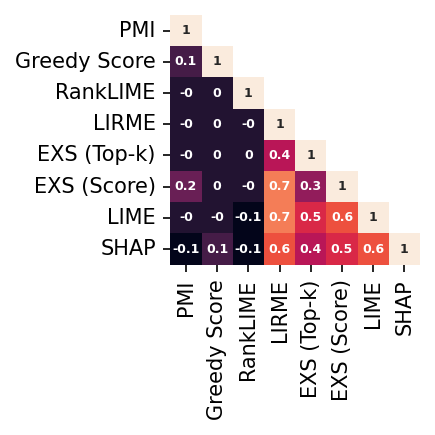

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)

similarity_upper[np.triu_indices(similarity_upper.shape[0], +1)] = np.nan
sns.heatmap(similarity_upper, xticklabels=exp_we_care_about_alt[:-1], cbar=False, yticklabels=exp_we_care_about_alt[:-1], annot=True, annot_kws={"fontsize":6, 'fontweight':'bold'})
plt.tight_layout()
plt.savefig('./img/pairwise_synthetic.pdf')
plt.show()

In [48]:
one_exp = {}
for s in exp_we_care_about[:-1]:
    one_exp[s] = q_exps[s][0]

In [49]:
colors = ['turquoise',  'red',  'blue', 'gold', 'lightgreen', 'magenta', 'darkorange', 'brown', 'black']

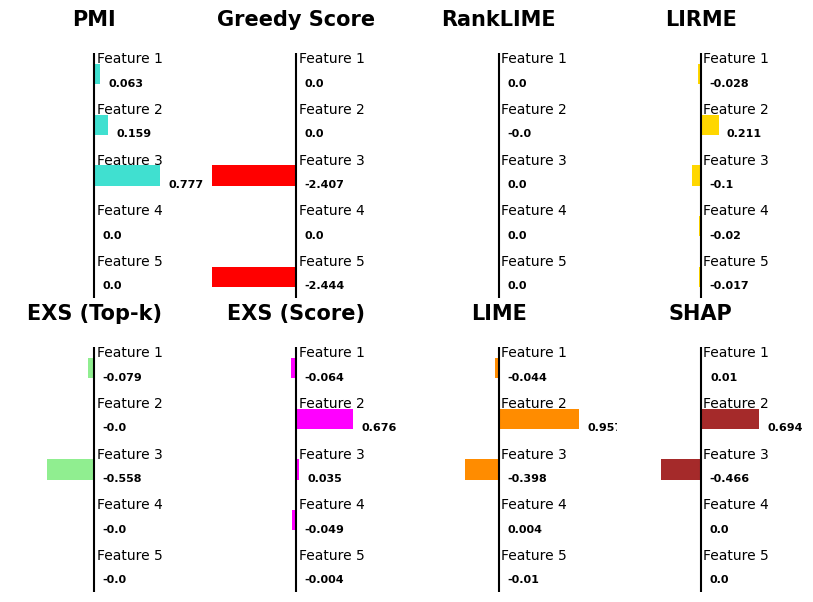

In [50]:
#fig, ax = plt.subplots(2, 4, figsize=(20, 10), sharey=True, dpi=120)
fig, ax = plt.subplots(2, 4, figsize=(10, 7),  sharey=True, dpi=100)
ax = ax.ravel()
y_pos = np.arange(valid_scaled.shape[1])
#titles = ['Greedy-Score', 'PMI', 'Grad', 'RPI']
#feat_names = ['tf_body', 'tf_anchor', 'tf_title', 'tf_url', 'tf_all_document']
ax[0].invert_yaxis() 
feat_names = []
for i in range(1, 6):
    feat_names.append('Feature {}'.format(i))
    
for i in range(8):    
    ax[i].set_title(exp_we_care_about_alt[i], fontsize=15, fontweight='bold', pad=20)
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])
    #ax[i].set_ylabel('', labelpad=25)
    ax[i].tick_params(left = False, bottom = False)
    #ax[i].set_yticks(np.arange(len(features)))
    #ax[i].set_yticklabels(features, fontsize=17)
    ax[i].set_yticklabels([])
    ax[i].set_xlim([-1, 1])
    ax[i].barh(y_pos[:5], one_exp[exp_we_care_about[i]], align='center', height=0.4, color=colors[i])
    #ax[i].set_yticks(y_pos)
    #ax[i].set_yticklabels(features, fontsize= 18)
    ax[i].axvline(x=0, c='black')

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    padding = 0.23
    #for j in range(len(sel_feats)):
    #for j in range(len(one_exp[subset_exps[i]])):
    for j in range(5):
        
        if one_exp[exp_we_care_about[i]][j] < 0:
            x_pos_ = 0.1
        else: 
            x_pos_ = one_exp[exp_we_care_about[i]][j] + 0.1
        
        ax[i].text(x_pos_, j + padding, np.round(one_exp[exp_we_care_about[i]][j], 3), color='black', fontweight='bold', fontsize=8)
        ax[i].text(0.03, j - padding, feat_names[j], color='black',  fontsize=10)
        
plt.savefig("./img/query_exp_example.pdf", bbox_inches='tight')